

### Install and load packages and set up environment


In [11]:
#!pip install foursquare h3pandas geojson geopy

import os
from getpass import getpass
#import foursquare
from google.colab import drive
import pandas as pd
import geopandas
#import h3pandas
import io
import folium
import folium.plugins

import numpy as np
import itertools
from shapely.geometry import Point

#drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/daycare/')

# Read school districts geojson for area coverage.


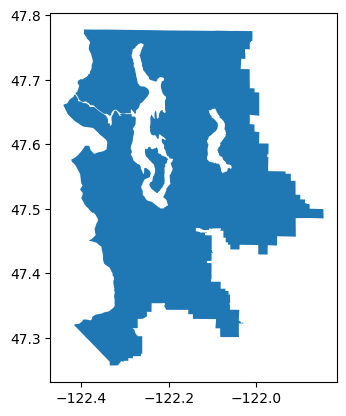

In [29]:
school_districts = geopandas.read_file('School_Districts_in_King_County___schdst_area.geojson')
polygon = school_districts[school_districts['NAME'].isin(['Seattle','Mercer Island','Northshore','Federal Way', 'Kent','Shoreline','Renton','Highline','Tukwila','Bellevue','Lake Washington','Issaquah'])]
# use shared identifier to dissolve all to single polygon
polygon['id'] = 0
polygon = polygon.dissolve(by='id')
polygon.plot()

## Create smaller Met Area

<Axes: >

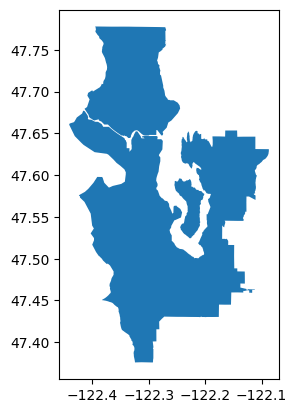

In [30]:
school_districts = geopandas.read_file('School_Districts_in_King_County___schdst_area.geojson')
# Reduce number of districts
polygon = school_districts[school_districts['NAME'].isin(['Seattle','Mercer Island','Shoreline','Renton','Highline','Tukwila','Bellevue'])]
polygon['id'] = 0
polygon = polygon.dissolve(by='id')
polygon.plot()

# Set up for API calls

## Declare uniform points function - to later search API at different points

In [13]:
# Ignore warnings
pd.options.mode.chained_assignment = None

def Uniform_Points_in_Polygon(polygon, number_x, number_y):
    # get bounds
    polygon_bounds = pd.DataFrame(polygon.bounds)
    points = []
    minx = polygon.bounds.iloc[0,0]
    maxx = polygon.bounds.iloc[0,2]
    miny = polygon.bounds.iloc[0,1]
    maxy = polygon.bounds.iloc[0,3]
    # create invervals within bounds
    points = pd.DataFrame(itertools.product(np.linspace(minx, maxx,number_x), np.linspace(miny, maxy,number_y)))
    points=geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(x = points[0],y = points[1]),crs='epsg:4326')
    points = geopandas.sjoin(points, polygon, how='inner', predicate='within')
    return(points)

## Points for listings (Zillow API)

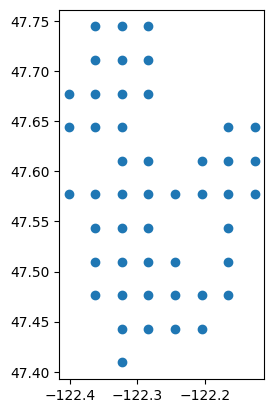

In [36]:
# Use smaller Seattle area
points_for_listings = Uniform_Points_in_Polygon(polygon, 10, 13) # Less points as expensive API
points_for_listings.plot()
points_for_listings = points_for_listings.get_coordinates()

### Check points by drawing them with radius

In [ ]:
# Test points
import pandas as pd
import io
import folium
import folium.plugins
# Use radius for search: 2 miles radius
points_for_listings['radius'] = 3200
listings_map = folium.Map([points_for_listings.y.mean(),points_for_listings.x.mean(),], zoom_start=12)

# try MarkerCluster
#cluster = folium.plugins.MarkerCluster().add_to(listings_map)
# Bubble data showing radius of search
for y,x,radius in zip(points_for_listings.y,points_for_listings.x,points_for_listings.radius):
    folium.vector_layers.Circle(
        location=[y,x],
        tooltip=str(radius),
        radius=radius,
        color='#3186cc',
        fill=True,
        popup="{} meters".format(radius),
        fill_color='#3186cc'
    ).add_to(listings_map) # or cluster

#listings_map.add_child(cluster)

listings_map
# Not great as misses parts of Mercer Island

### Format coordinates for Zillowish API

In [17]:
areas_zillow = []
# for each point extract lat and long for API
for i in range(len(points_for_listings)):

  areas_zillow.append(str(round(points_for_listings.iloc[i,0],5))+' '+str(round(points_for_listings.iloc[i,1],5)))

print(areas_zillow)

['-122.40188 47.57687', '-122.40188 47.6439', '-122.40188 47.67742', '-122.36251 47.47631', '-122.36251 47.50983', '-122.36251 47.54335', '-122.36251 47.57687', '-122.36251 47.6439', '-122.36251 47.67742', '-122.36251 47.71094', '-122.36251 47.74446', '-122.32314 47.40928', '-122.32314 47.4428', '-122.32314 47.47631', '-122.32314 47.50983', '-122.32314 47.54335', '-122.32314 47.57687', '-122.32314 47.61039', '-122.32314 47.6439', '-122.32314 47.67742', '-122.32314 47.71094', '-122.32314 47.74446', '-122.28378 47.4428', '-122.28378 47.47631', '-122.28378 47.50983', '-122.28378 47.54335', '-122.28378 47.57687', '-122.28378 47.61039', '-122.28378 47.67742', '-122.28378 47.71094', '-122.28378 47.74446', '-122.24441 47.4428', '-122.24441 47.47631', '-122.24441 47.50983', '-122.24441 47.57687', '-122.20504 47.4428', '-122.20504 47.47631', '-122.20504 47.57687', '-122.20504 47.61039', '-122.16567 47.47631', '-122.16567 47.50983', '-122.16567 47.54335', '-122.16567 47.57687', '-122.16567 47.61

### Create list of strings that representing polygons from districts
**Not used, for if using seperate school districts within polygon search**

In [52]:
school_districts = geopandas.read_file('School_Districts_in_King_County___schdst_area.geojson')
polygon = school_districts[school_districts['NAME'].isin(['Seattle','Mercer Island','Shoreline','Renton','Highline','Tukwila','Bellevue'])]

sep_polygon = list(polygon.geometry)
# Seperate Seattle multipolygon in to seperate polygons
sep_seattle = list(sep_polygon[0].geoms)
sep_polygon = sep_seattle + sep_polygon[1:]
import re
new_sep_polygons = []
for i in range(len(sep_polygon)):
  new_sep_polygons.append(re.sub(r".*\(\((.*)\)\)", r'\1', str(sep_polygon[i])))

### Create simplified polygon (reduce number of points) from single polygon, to cover whole Seattle Met Area, extending with buffer to include all features when simplified

In [ ]:
# buffer extends polygon, simplify reduces points
# Use smaller Met area
simplified = polygon.buffer(0.004, resolution = 2).simplify(0.005)
simplified.plot()

# extract the coordinates to a dataframe
simplified = simplified.get_coordinates()

# iterate over each row to extract lat/long in correct format to then be parsed as a string
areas =  []
for i in range(len(simplified)):
 areas.append(str(round(simplified.iloc[i,1],5))+' '+str(round(simplified.iloc[i,0],5)))
# first point must be last
areas.append(str(round(simplified.iloc[0,1],5))+' '+str(round(simplified.iloc[0,0],5)))

print(len(areas))
print(*areas,sep=',')
# Create
polygon_simplified = ','.join(areas)

## Get results from Zillow API using polygon

In [ ]:
import requests
import time

url = "https://zillow56.p.rapidapi.com/search"
headers = {
	"X-RapidAPI-Key": "ab4b4a80ddmshd6b4716f2ba5b92p14baf9jsn99f4ebf9831c",
	"X-RapidAPI-Host": "zillow56.p.rapidapi.com"
}
# Pull results of seperate pages from polygon
for i in range(1,29):
  querystring = {"polygon":polygon_simplified,"page":str(i)}
  print("attempting page "+str(i))
  response = requests.get(url, headers=headers, params=querystring)
  dataframe_response = pd.json_normalize(response.json(), record_path = 'results', meta = ['resultsPerPage', 'totalPages','totalResultCount'])
  dataframe_response['page'] = i
  all_listings = pd.concat([all_listings, dataframe_response]).reset_index(drop = True)
  print("page "+str(i)+" success")
  # sleep between calls to not exceed api limit
  time.sleep(1)

### Check for duplicates and write to file

In [ ]:
all_listings['dup']=all_listings.duplicated(subset = "zpid",keep = False) # keep = False, mark all duplicated records
# Sort by ZPID to view
all_listings.loc[all_listings['dup']==True].sort_values(by='zpid')
# and drop duplicates keeping only one record (first)
all_listings = all_listings.drop_duplicates("zpid", keep = 'first')
all_listings.to_csv('current-sales-king-co-sabri.csv')

## Extract more results from other Zillow API using points

In [ ]:
import requests
import time
url = "https://zillow-com1.p.rapidapi.com/propertyExtendedSearch"

headers = {
	"X-RapidAPI-Key": "ab4b4a80ddmshd6b4716f2ba5b92p14baf9jsn99f4ebf9831c",
	"X-RapidAPI-Host": "zillow-com1.p.rapidapi.com"
}

for i in range(len(areas_zillow)):
  # Use coordinates, 2 as radius (miles), ForSale only
  querystring = {"coordinates":areas_zillow[i]+",2","status_type":"ForSale"}
  response = requests.get(url, headers = headers, params = querystring)
  json_response = response.json()
  # Start of if statement if need to deal with empty/invalid results. Not used
  #  if json_response == {'resultsPerPage': 41,
  # 'totalPages': 0,
  # 'schools': {},
  # 'totalResultCount': 0,
  # 'currentPage': 1} or json_response ..
  dataframe = pd.json_normalize(json_response, record_path = 'props', meta = ['resultsPerPage', 'totalPages','totalResultCount', 'currentPage'])
  dataframe['api_call_no']=i
  dataframe['search_long_lat'] = areas_zillow[i]
  if(i == 0):
    all_listings = dataframe
  elif(i>1):
    all_listings = pd.concat([all_listings, dataframe]).reset_index(drop = True)
  # no more than 10 calls a minute on API tier: wait after 10 for over a minute
  if i%10==0:
    time.sleep(70)

# Remove duplicated from result
all_listings = all_listings.drop_duplicates(subset = "zpid")

all_listings.to_csv('current-sales-king-co.csv')

## Load Zillow listings data and merge, add h3 index and pricepersqft

In [ ]:
listings_sabri = pd.read_csv('current-sales-king-co-sabri.csv').reset_index(drop = True)
# rename sabri columns to match other dataset
listings_sabri = listings_sabri.rename(columns={"homeType": "propertyType", "homeStatus": "listingStatus"})

listings = pd.read_csv('current-sales-king-co.csv').reset_index(drop = True)

# concat inner to keep common columns only, reset index and drop duplicates!
listings = pd.concat([listings,listings_sabri], join = 'inner').reset_index(drop = True).drop_duplicates('zpid')
print('Total records:', len(listings))

# drop indexes if there
listings = listings.drop(listings.columns[[0]], axis=1)
# add h3 resolution 8 (0.74 km2)
listings = listings.h3.geo_to_h3(resolution = 8, lat_col = 'latitude', lng_col = 'longitude')
# remove empty long lat (where h3 could not be applied)
listings = listings.loc[listings.index!='0']
# add h3 parent resolution 7
listings = listings.h3.h3_to_parent(7)
# add geometry for h3 8`
listings = listings.h3.h3_to_geo_boundary()
# add price_per_sqft where living area present and greater than one
listings.loc[listings['livingArea'] > 0, 'pricePerSqft'] = listings.loc[listings['livingArea'] > 0, 'price']/listings.loc[listings['livingArea'] > 0, 'livingArea']

1564


# Foursquare API for points of interest
Using daycare centres as example

### Points for Foursquare API

['47.65096,-122.4226', '47.56628,-122.40395', '47.65096,-122.40395', '47.67213,-122.40395', '47.6933,-122.40395', '47.50277,-122.3853', '47.52394,-122.3853', '47.54511,-122.3853', '47.56628,-122.3853', '47.58745,-122.3853', '47.62979,-122.3853', '47.65096,-122.3853', '47.67213,-122.3853', '47.6933,-122.3853', '47.46044,-122.36666', '47.50277,-122.36666', '47.52394,-122.36666', '47.54511,-122.36666', '47.56628,-122.36666', '47.62979,-122.36666', '47.65096,-122.36666', '47.67213,-122.36666', '47.6933,-122.36666', '47.71447,-122.36666', '47.73564,-122.36666', '47.75681,-122.36666', '47.4181,-122.34801', '47.43927,-122.34801', '47.46044,-122.34801', '47.48161,-122.34801', '47.50277,-122.34801', '47.52394,-122.34801', '47.54511,-122.34801', '47.56628,-122.34801', '47.58745,-122.34801', '47.62979,-122.34801', '47.65096,-122.34801', '47.67213,-122.34801', '47.6933,-122.34801', '47.71447,-122.34801', '47.73564,-122.34801', '47.75681,-122.34801', '47.4181,-122.32936', '47.43927,-122.32936', '47

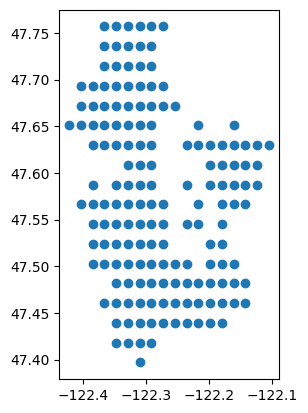

In [28]:
points = Uniform_Points_in_Polygon(polygon, 20, 20)
points.plot()

points_for_search = points.get_coordinates()
areas = []
for i in range(len(points_for_search)):

  areas.append(str(round(points_for_search.iloc[i,1],5))+','+str(round(points_for_search.iloc[i,0],5)))

print(areas)

### Request from Foursquare API

In [ ]:
import requests

headers = {
    "Accept": "application/json",
    "Authorization": "fsq3qF3/i2gWdxoslyq3uksoE3V+hxbOKBY+WbOHy17xfwU="
}

for i in range(0,len(areas)):

  latlong = str(areas[i])
  # Radius 2000m, categories 11026 (daycares), limit 50 (max)
  url = "https://api.foursquare.com/v3/places/search?ll="+latlong+"&radius=2000&v=20240419&categories=11026&limit=50"
  response = requests.request("GET", url, headers=headers)
  json_response = response.json()
  dataframe = pd.json_normalize(json_response,record_path = ['results'],meta=[['context', 'geo_bounds','circle','center','latitude'],['context', 'geo_bounds','circle','center','longitude'],['context', 'geo_bounds','circle','radius']])
  dataframe = dataframe.rename({"context.geo_bounds.circle.center.latitude": "search_latitude", "context.geo_bounds.circle.center.longitude": "search_longitude","context.geo_bounds.circle.radius": "search_radius" },axis = 1)
  if(i == 0):
    all_data = dataframe
  elif(i>0):
    all_data = pd.concat([all_data, dataframe]).reset_index(drop = True)

# Remove duplicated from result
all_data = all_data.drop_duplicates(subset = "fsq_id")

all_data.to_csv('daycares-west-king-county.csv')

In [ ]:
listings.to_csv('all-listings.csv')